# Inferential Statistics: California Housing
Raphassit Suwiwatchai

In [3]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, norm
from itertools import combinations

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [4]:
# Here we would want to check the contents of each variables
df = pd.read_csv("dataset/California Houses.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
# The dataset documentation said that this data is not yet been cleaned, so we need to run some checks first

#-------------- Check for null values --------------#
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)
df = df.dropna() # Drop null values (minimal impact as our dataset contain over 20,000 datapoints)

#-------------- Check for duplicates --------------#
missing_values = df.duplicated().sum()
print("Duplicate Values:\n", missing_values)
df = df.drop_duplicates() # Drop duplicates

df

Missing Values:
 longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64
Duplicate Values:
 0


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


## Data Exploration (15 Points)
- Plot distributions of at least three numeric features (e.g. histograms, density plots).
- Compute mean and variance for the corresponding numeric features (and any additional summary statistics if desired)
- Identify any outliers in the distributions that lie outside three standard deviations from the mean.

Now the next step is to plot histogram, boxplot, and scatterplot for each variable to better visualise the data. The justification for each types of plots are as follows:

**Histogram:** Help us see the spread and skewness of data. It would also help us identify multi-modality (if any), to better visualise subgroups as well as revealing data concentrations.

**Box Plot:** Help identify outliers and understand the dataset;s variance.

**Scatter Plot:** Help identify relationship between variables, outliers, and clusters.

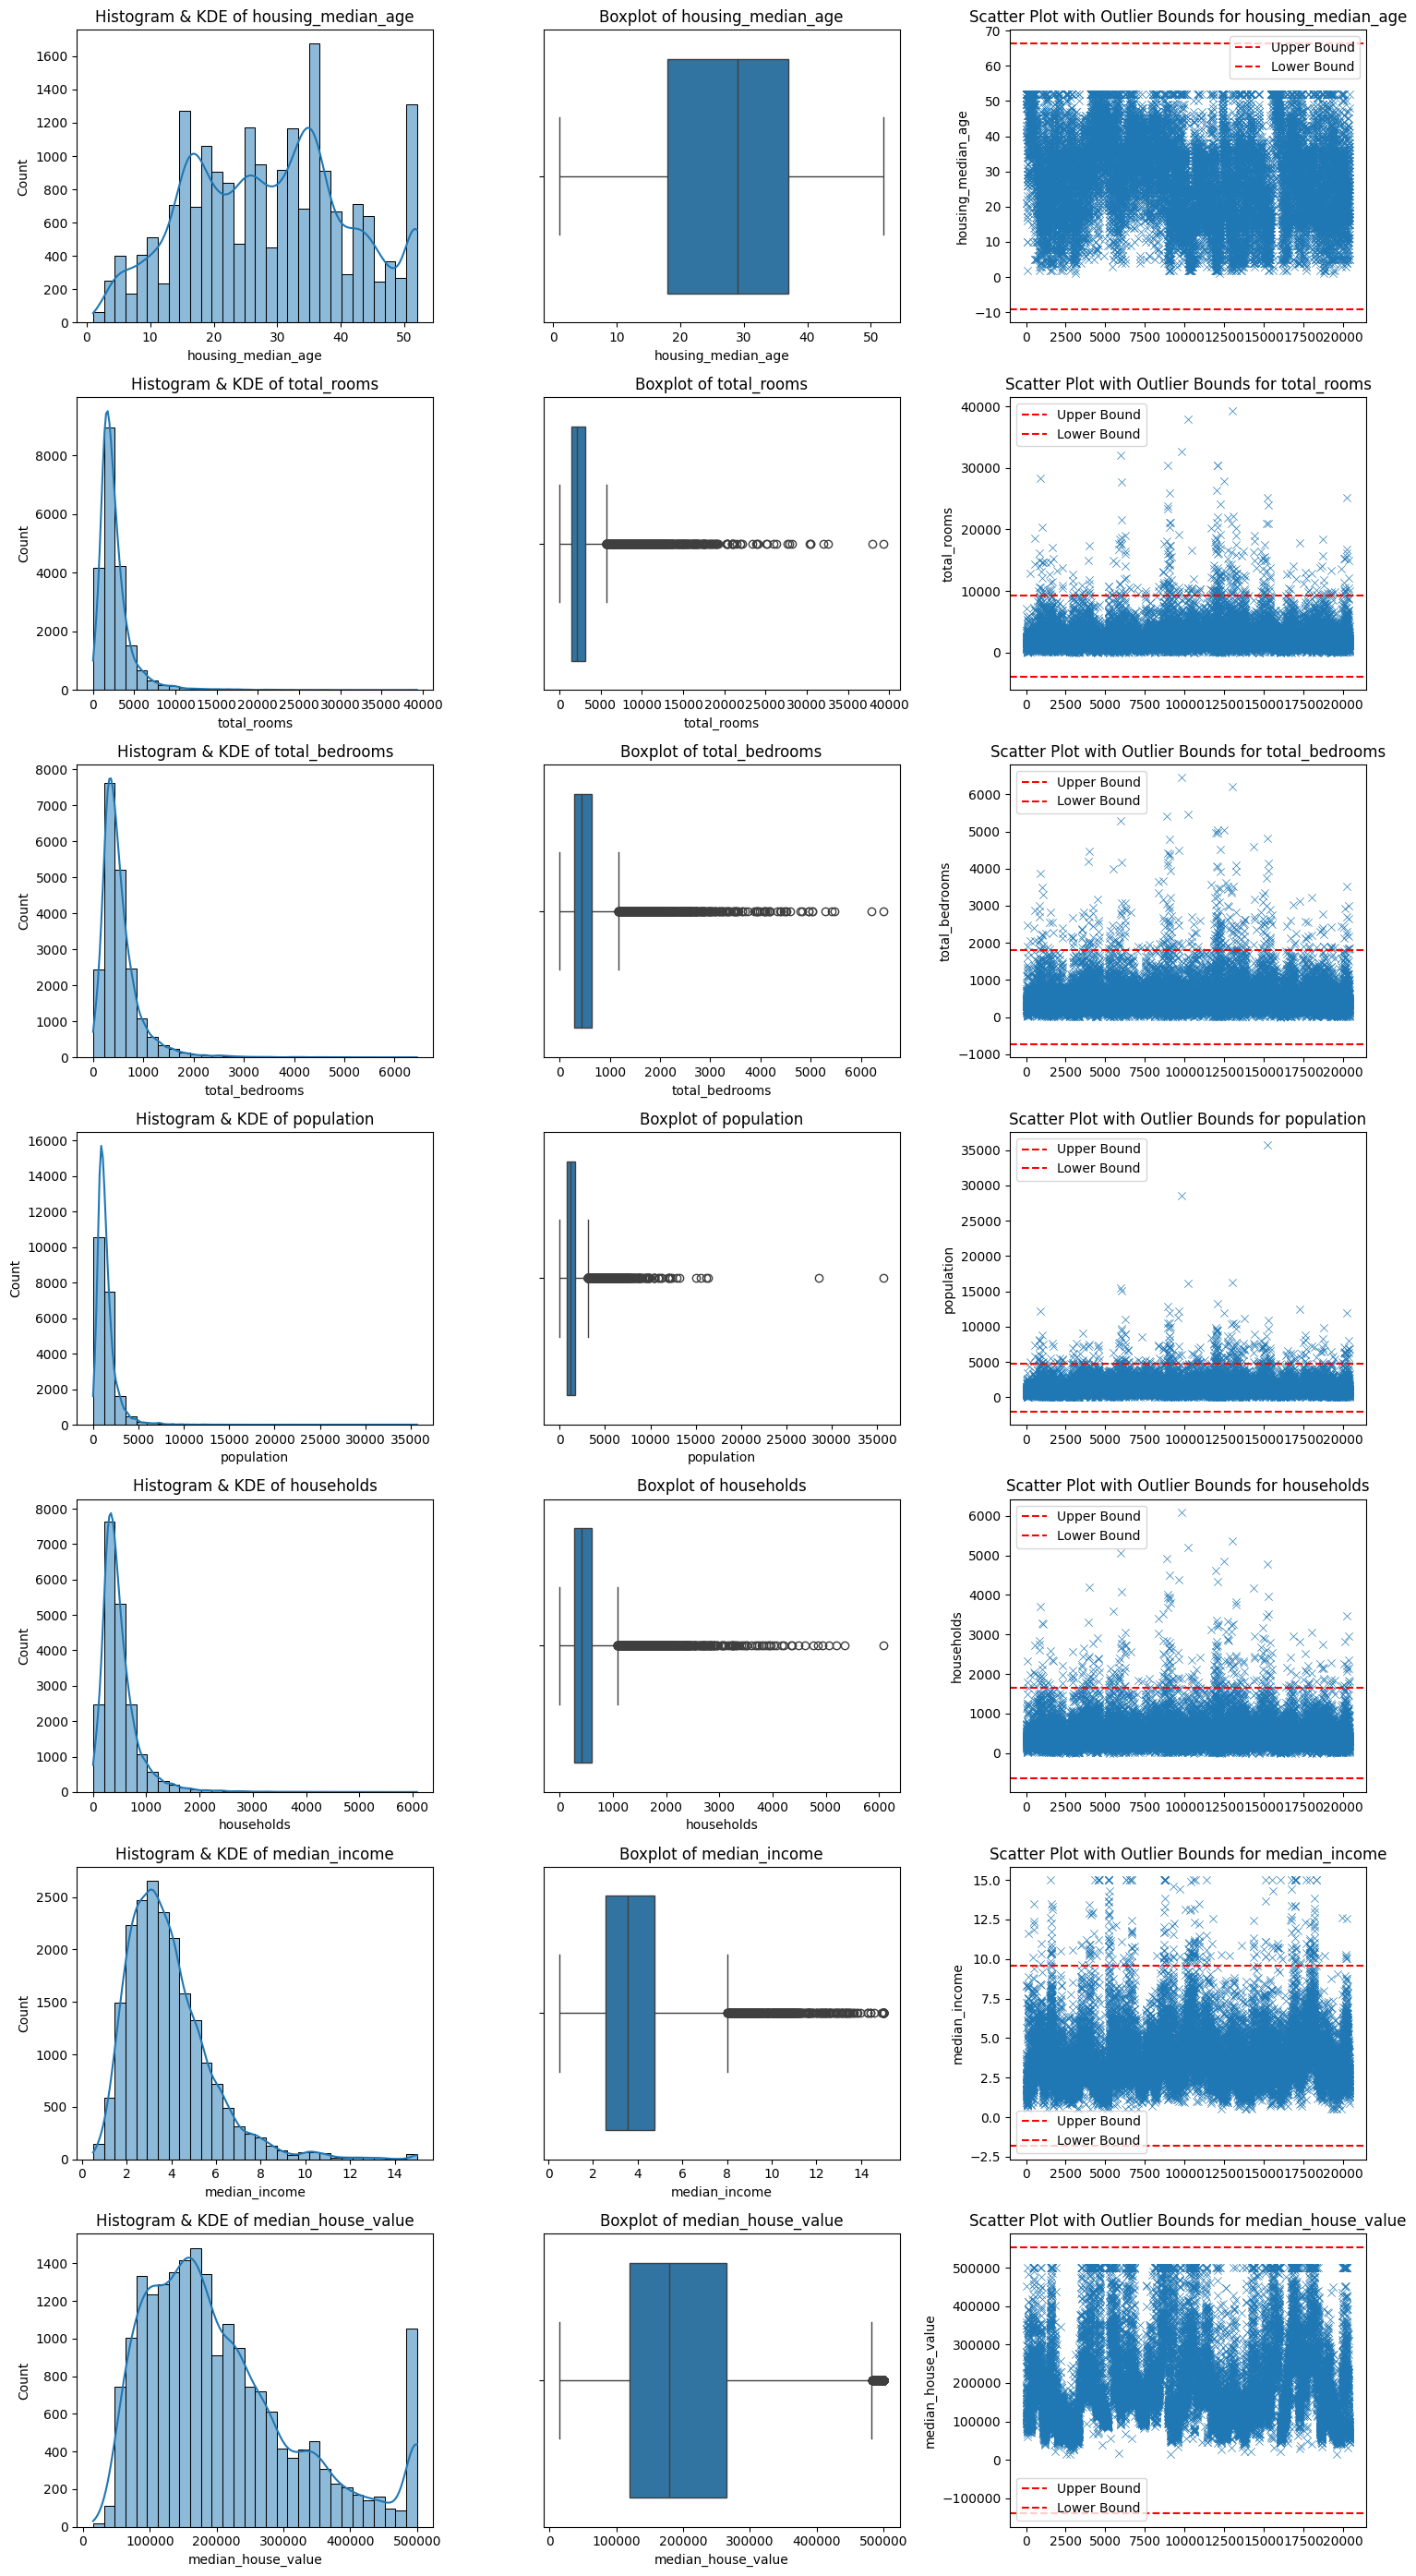

In [6]:
# We can't plot distribution for non-numeric features (remove string and spatial features)
numerical_columns = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

# Plot
fig, axes =plt.subplots(len(numerical_columns), 3, figsize=(15, 4 * len(numerical_columns)))

for i, feature in enumerate(numerical_columns):
    # Histogram & Density Plot
    sns.histplot(df[feature], bins=30, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram & KDE of {feature}')

    # Boxplot
    sns.boxplot(x=df[feature], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {feature}')

    mean = df[feature].mean()
    std_dev = df[feature].std()
    threshold_upper = mean + 3 * std_dev
    threshold_lower = mean - 3 * std_dev

    # Scatter plot
    sns.scatterplot(y=df[feature], x=np.arange(len(df)), marker='x', ax=axes[i, 2])
    axes[i, 2].axhline(threshold_upper, color='red', linestyle='dashed', label="Upper Bound")
    axes[i, 2].axhline(threshold_lower, color='red', linestyle='dashed', label="Lower Bound")
    axes[i, 2].set_title(f'Scatter Plot with Outlier Bounds for {feature}')
    axes[i, 2].legend()

plt.tight_layout()
plt.show()

In [7]:
# Compute summary statistics
summary_stats = df[numerical_columns].describe()
print("Summary Statistics:\n", summary_stats)

# Find Outliers
outlier_dict = {}
for feature in numerical_columns:
    mean = df[feature].mean()
    std_dev = df[feature].std()
    threshold_upper = mean + 3 * std_dev
    threshold_lower = mean - 3 * std_dev
    outlier_dict[feature] = df[(df[feature] > threshold_upper) | (df[feature] < threshold_lower)][feature].values

# Display outliers
outlier_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in outlier_dict.items()]))
print("Outliers Detected:\n", outlier_df)

Summary Statistics:
        housing_median_age   total_rooms  total_bedrooms    population  \
count        20433.000000  20433.000000    20433.000000  20433.000000   
mean            28.633094   2636.504233      537.870553   1424.946949   
std             12.591805   2185.269567      421.385070   1133.208490   
min              1.000000      2.000000        1.000000      3.000000   
25%             18.000000   1450.000000      296.000000    787.000000   
50%             29.000000   2127.000000      435.000000   1166.000000   
75%             37.000000   3143.000000      647.000000   1722.000000   
max             52.000000  39320.000000     6445.000000  35682.000000   

         households  median_income  median_house_value  
count  20433.000000   20433.000000        20433.000000  
mean     499.433465       3.871162       206864.413155  
std      382.299226       1.899291       115435.667099  
min        1.000000       0.499900        14999.000000  
25%      280.000000       2.563700  

The data show that the dataset is extremely skewed

## Verifying the Central Limit Theorem (CLT) (20 Points)

- Choose a numerical variable (with enough data) and draw repeated samples of various sizes (e.g. 10, 50, 200).
- For each sample size, compute the sample means repeatedly (like resampling approach)
- Visualise how these sample means distribute, and discuss how it relates to the Central Limit Theorem and the Law of Large Numbers

In [8]:
## -- PART A -- ##

# Selecting a variable to test CLT
variable = 'median_income'

# Sample sizes for CLT verification
sample_sizes = [10, 50, 200]
num_samples = 1000

# Generating sample means for each sample size
sample_means = {}

for size in sample_sizes:
    means = [
        df[variable].sample(size).mean() for _ in range(num_samples)
    ]
    sample_means[size] = means

sample_means_df = pd.DataFrame(sample_means)

sample_means_df

,10,50,200
0,3.18145,4.268738,3.834936
1,3.23070,3.602486,3.794346
2,3.65742,3.561212,3.863374
3,4.79742,3.884146,3.919557
4,3.00620,3.881260,3.843315
...,...,...,...
995,3.02067,3.508496,3.958712
996,2.99870,3.724146,3.734284
997,4.18949,3.881100,3.685181
998,4.42138,3.673448,4.004456


In [9]:
## -- PART B -- ##
print("Summary Statistics for Sample Means:\n", sample_means_df.describe())

Summary Statistics for Sample Means:
                10           50           200
count  1000.000000  1000.000000  1000.000000
mean      3.886296     3.879650     3.874991
std       0.601028     0.259735     0.131142
min       2.390450     3.018130     3.450519
25%       3.476300     3.707704     3.783980
50%       3.831200     3.859991     3.864068
75%       4.241202     4.040696     3.957050
max       6.217660     4.684458     4.303711


The results show that while the mean is very close to each other, aligning with the dataset's mean. Standard deviation decreases as sample size increases and smaller sample size have wider range compared to bigger sample sizes.

When plotting, we will also plot the theoretical normal distribution. Here we use $\pm4\sigma$ because it covers 99.994% of the data, ensuring that almost all data points in the distribution are included in the plot

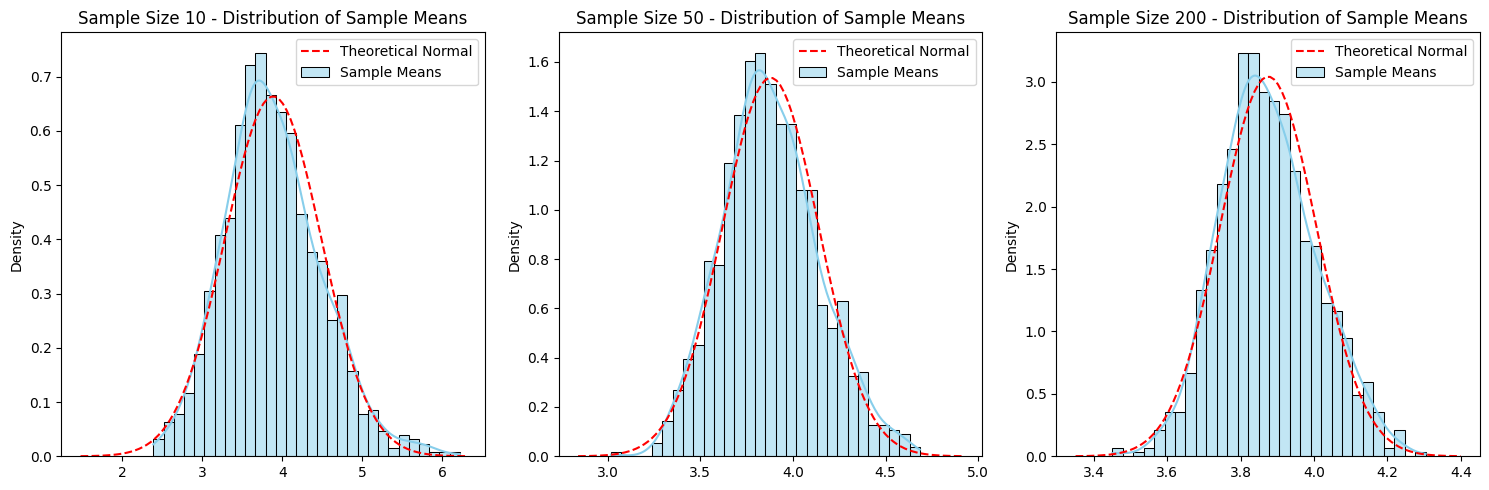

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, size in enumerate(sample_sizes):
    # Plot histogram with KDE
    sns.histplot(sample_means[size], bins=30, kde=True, ax=axes[i], color='skyblue', stat="density", label="Sample Means")

    # Compute theoretical normal distribution
    mu = np.mean(sample_means[size])
    sigma = np.std(sample_means[size], ddof=1)
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    y = norm.pdf(x, mu, sigma)

    # Plot
    axes[i].plot(x, y, color='red', linestyle='dashed', label="Theoretical Normal")
    axes[i].set_title(f'Sample Size {size} - Distribution of Sample Means')
    axes[i].legend()

plt.tight_layout()
plt.show()


The histogram plot reinforces our finding, successfully validating CLT and confirms that inferential statistics can be applied to this dataset. To show mathematically prove that the distribution of sample mean tends towards normality as sample size increase, we can use Shapiro-Wilk test (dataset is big but not too big, making this test suitable).

In [11]:
shapiro_results = []

for size in sample_sizes:
    sample_data = sample_means[size]
    shapiro_stat, shapiro_p = shapiro(sample_data)

    shapiro_results.append([size, shapiro_stat, shapiro_p])

pd.DataFrame(shapiro_results, columns=["Sample Size", "Shapiro-Wilk Statistic", "p-value"])


,Sample Size,Shapiro-Wilk Statistic,p-value
0,10,0.988437,4.320251e-07
1,50,0.994728,1.462955e-03
2,200,0.995050,2.407926e-03


Looking at the p-value, we can see that when sample size =10, we reject normality (as 4.27e-11 << 0.5) and when sample size = 200, we fail to reject normality.

## Hypothesis Testing (25 Points)
- Perform at least one hypothesis test relevant to your dataset. For example (not exhaustive, you can come up with different ones):
    - Test whether the mean of a numeric feature equals a hypothesized value.– Compare means across two groups.
    - State the null and alternative hypotheses clearly, choose a significance level (e.g.α =0.05), show the test statistic or p-value, and interpret the result.
- Calculate confidence interval (you can pick the boundary)

In [12]:
# Define all the fixed variables we will be using throughout
sample_size = 500 
num_samples = 1000
alpha = 0.05

### Hypothesis Test #1: Does the average income of people living in the bay area significantly different than everywhere else?

Null Hypothesis: The mean of 'median income' is equal to a hypothesised value based on CLT

Alternative Hypothesis: The mean of median_income differs from the hypothesised value

Significance Level: 0.05

In [13]:
overall_mean = np.mean(df['median_income'])
near_bay_income = df[df['ocean_proximity'] == 'NEAR BAY']['median_income']

# Generate distribution
sample_means = []
for _ in range(num_samples):
    sample = np.random.choice(near_bay_income, size=sample_size, replace=True)
    sample_means.append(sample.mean())

# Compute mean and std
sample_mean_clt = np.mean(sample_means)
sample_std_clt = np.std(sample_means, ddof=1)
SE_clt = sample_std_clt / np.sqrt(num_samples)

# Two-tailed hypothesis test
t_stat = (sample_mean_clt - overall_mean) / SE_clt
p = 2 * (1 - stats.t.cdf(abs(t_stat), df=sample_size - 1))

# Confidence Interval Calculation
t_crit = stats.t.ppf(1 - alpha / 2, df=sample_size - 1)
ci_low = (sample_mean_clt - overall_mean) - t_crit * SE_clt
ci_high = (sample_mean_clt - overall_mean) + t_crit * SE_clt

# Display Results
print("Hypothesis Test #1")
print(f"Sample Mean: {sample_mean_clt:.4f}")
print(f"Overall Mean: {overall_mean:.4f}")
print(f"t-statistic = {t_stat:.4f}")
print(f"p-value = {p:.6f}")
print(f"95% CI: [{ci_low:.4f}, {ci_high:.4f}]")

Hypothesis Test #1
Sample Mean: 4.1746
Overall Mean: 3.8712
t-statistic = 108.3663
p-value = 0.000000
95% CI: [0.2980, 0.3090]


As p-value is smaller than 0.05, we found that there is a signficant difference in income between those living on the near the bay and the rest of the area. In the context of the housing market this could mean that people living near the bay are more wealthy than the overall population.

### Hypothesis Test #2: Do wealthier areas have significantly larger homes

Null Hypothesis: The mean rooms per person is the same for high-income and low-income areas.

Alternative Hypothesis: The mean rooms per person is different between high-income and low-income areas (two-tailed test).

Significance Level: 0.05

C:\Users\beam_\AppData\Local\Temp\ipykernel_31956\2109031970.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([low_income_samples, high_income_samples], labels=["Low Income", "High Income"])


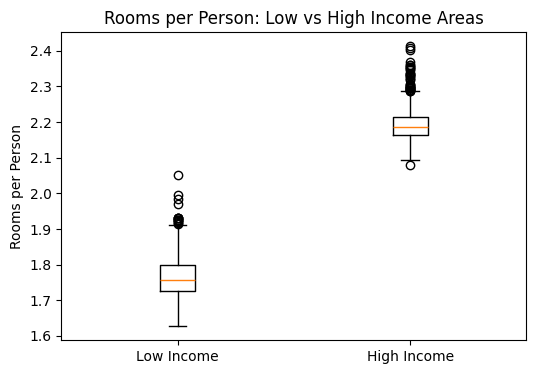

In [14]:
df['rooms_per_person'] = df['total_rooms'] / df['population']

# Define income threshold (median split)
income_median_threshold = df['median_income'].median()
low_income_df = df[df['median_income'] <= income_median_threshold]
high_income_df = df[df['median_income'] > income_median_threshold]

# Generate sample means
# We also want to ensure that we don't sample more data than it is available
low_sample_size = min(len(low_income_df), sample_size)
high_sample_size = min(len(high_income_df), sample_size)

low_income_samples = []
high_income_samples = []

for i in range(num_samples):
    low_sample = low_income_df['rooms_per_person'].sample(n=low_sample_size, replace=True).mean()
    high_sample = high_income_df['rooms_per_person'].sample(n=high_sample_size, replace=True).mean()
    
    low_income_samples.append(low_sample)
    high_income_samples.append(high_sample)

# Plot
plt.figure(figsize=(6,4))
plt.boxplot([low_income_samples, high_income_samples], labels=["Low Income", "High Income"])
plt.title("Rooms per Person: Low vs High Income Areas")
plt.ylabel("Rooms per Person")
plt.show()

In [15]:
# Two Sample 2-tail T-test Code
t_stat, p = stats.ttest_ind(high_income_samples, low_income_samples, equal_var=False)

mean_low_income = np.mean(low_income_samples)
mean_high_income = np.mean(high_income_samples)

df_degrees = num_samples - 1

# std calculation
SE_diff = np.sqrt((np.var(low_income_samples, ddof=1) / num_samples) + 
                  (np.var(high_income_samples, ddof=1) / num_samples))

t_crit = stats.t.ppf(1 - alpha/2, df_degrees)

mean_diff = mean_high_income - mean_low_income
ci_low = mean_diff - t_crit * SE_diff
ci_high = mean_diff + t_crit * SE_diff

# Display results with confidence interval
print("Hypothesis Test #2")
print(f"t-statistic = {t_stat:.4f}")
print(f"p-value = {p:.6f}")
print(f"95% CI: [{ci_low:.4f}, {ci_high:.4f}]")

Hypothesis Test #2
t-statistic = 186.3954
p-value = 0.000000
95% CI: [0.4230, 0.4320]


We reject null hypothesis as there is significant difference in room per person between low and high-income people. This is somewhat expected that those who earns more are able to afford larger homes.

### Hypothesis 3: Is the housing median age greater than the hypothesised value?

Null hypothesis: Mean of 'housing_median_age' is equal to a hypothesized value

Alternative hypothesis: Mean of 'housing_median_age' is greater than the hypothesized value (one-tailed test)

In [16]:
sample_means = [np.mean(np.random.choice(df['housing_median_age'], sample_size, replace=True)) for _ in range(num_samples)]

sample_mean_clt = np.mean(sample_means)
sample_std_clt = np.std(sample_means, ddof=1)
SE_clt = sample_std_clt / np.sqrt(num_samples)

mu = 33 # Our hypothesis mean

t_stat = (sample_mean_clt - mu) / SE_clt

# 1-Tail, 1-Sample T-Test
p = 1 - stats.t.cdf(t_stat, df=num_samples-1)
df_degrees = num_samples - 1
t_crit = stats.t.ppf(1 - alpha/2, df_degrees)

# CI Calcuation
ci_low = sample_mean_clt - t_crit * SE_clt
ci_high = sample_mean_clt + t_crit * SE_clt

print("Hypothesis Test #3")
print(f"Sample Mean (from CLT samples): {sample_mean_clt:.4f}")
print(f"t-statistic = {t_stat:.4f}")
print(f"p-value = {p:.6f}")
print(f"95% CI: [{ci_low:.4f}, {ci_high:.4f}]")

Hypothesis Test #3
Sample Mean (from CLT samples): 28.6314
t-statistic = -240.5915
p-value = 1.000000
95% CI: [28.5958, 28.6671]


 ## Correlation Between Variables (15 Points)
 - Identify at least three couples of numeric variables in your dataset and compute their correlations (You can pick variables A B C and see how they correlate to variable D).
 - Create a scatter plot, for each couple of variables, and interpret the strength/direction of the relationship.

In [17]:

df['log_rooms_per_household'] = np.log1p(df['total_rooms'] / df['households'])
df['log_bedrooms_per_household'] = np.log1p(df['total_bedrooms'] / df['households'])
df['log_population_per_household'] = np.log1p(df['population'] / df['households'])


In [18]:
correlation_pairs = [
    ('median_income', 'median_house_value'),  # Expected Strong +ve
    ('log_rooms_per_household', 'median_house_value'),    # Expected Mod +ve
    ('log_population_per_household', 'median_house_value')          # Expected Mod -ve
]

correlation_results = {f"{x} & {y}": df[[x, y]].corr().iloc[0, 1] for x, y in correlation_pairs}

correlation_results_df = pd.DataFrame(list(correlation_results.items()), columns=["Variable Pair", "Correlation Coefficient"])

correlation_results_df

,Variable Pair,Correlation Coefficient
0,median_income & median_house_value,0.688355
1,log_rooms_per_household & median_house_value,0.240770
2,log_population_per_household & median_house_value,-0.246415


The first pair is a strong positive correlation, the second pair is a weak positive correlation, and the third pair is a technically a weak negative correlation but more no correlation.

This result shows that higher income is strongly correlated with more expensive houses, however the number of rooms only have a weak relation with the value of the house, suggesting that size alone does not drive house prices. Where the population density of the area barely affect housing price.

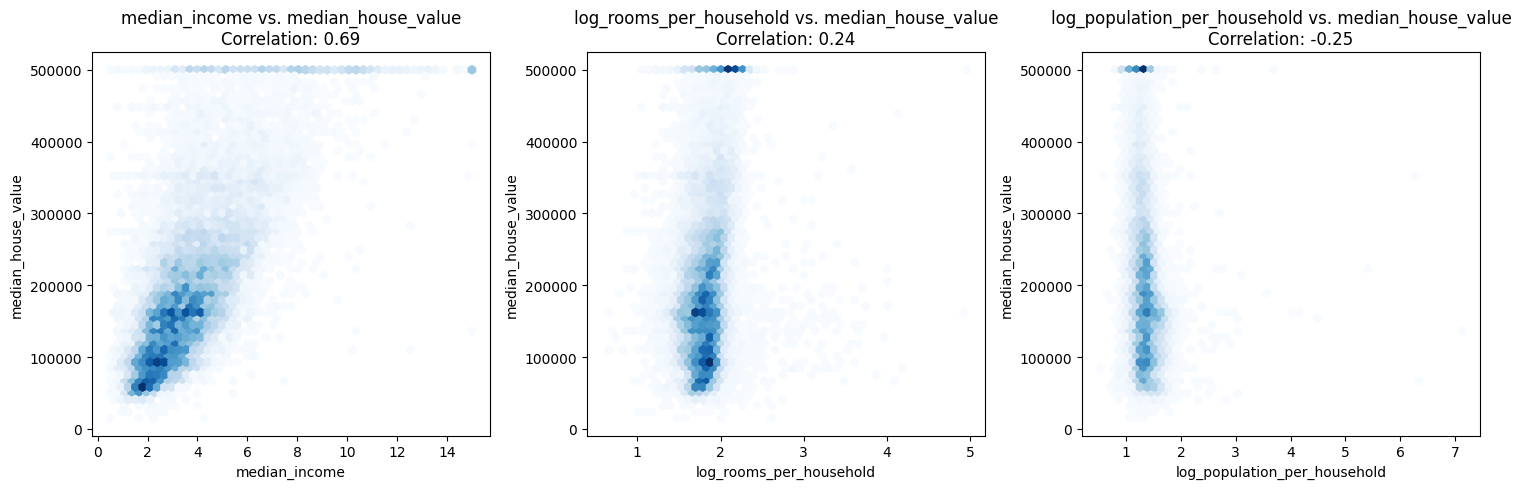

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (x, y) in enumerate(correlation_pairs):
    axes[i].hexbin(df[x], df[y], gridsize=50, cmap="Blues", mincnt=1)
    axes[i].set_title(f"{x} vs. {y}\nCorrelation: {correlation_results[f'{x} & {y}']:.2f}")
    axes[i].set_xlabel(x)
    axes[i].set_ylabel(y)

plt.tight_layout()
plt.show()


In [20]:
#Before we go into regression analysis, let's do another quick correlation analysis of the rest of the variables
correlation_matrix = (df.select_dtypes(include=['number'])).corr()
sorted_correlation = correlation_matrix['median_house_value'].sort_values(ascending=False)
print("Correlation Matrix:\n", sorted_correlation)

Correlation Matrix:
 median_house_value              1.000000
median_income                   0.688355
log_rooms_per_household         0.240770
rooms_per_person                0.208544
total_rooms                     0.133294
housing_median_age              0.106432
households                      0.064894
total_bedrooms                  0.049686
population                     -0.025300
longitude                      -0.045398
log_bedrooms_per_household     -0.079397
latitude                       -0.144638
log_population_per_household   -0.246415
Name: median_house_value, dtype: float64


## Regression Analysis and CLT Consideration (25 Points)
- Choose a numeric variable to be the response (dependent) variable, and at least one other variable (or multiple) as the predictor(s).
- Fit a linear regression model (simple or multiple). Summarize the regression coefficients, check the model fit (e.g. R2), and interpret your findings.
- To illustrate how the CLT impacts estimates of standard error in regression, randomly sample subsets of your dataset multiple times, re-fit the model each time, and observe how the estimated coefficients (and their standard errors) vary. Briefly discuss how these variations align with the Central Limit Theorem

In [21]:
all_predictors = ['median_income', 'total_rooms', 'housing_median_age', 'households', 'total_bedrooms', 'population','log_rooms_per_household','log_population_per_household']

regression_results = []

# Loop to find all combination
for r in range(1, len(all_predictors) + 1):
    for predictor_combination in combinations(all_predictors, r):
        X = df[list(predictor_combination)]
        y = df['median_house_value']
        
        # test-train
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mse)
        n = X_test.shape[0]  # observations
        k = X_test.shape[1]  # predictors
        adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1)) if n > k + 1 else None

        # Store results
        regression_results.append({
            "Predictors Used": ", ".join(predictor_combination),
            "Num Predictors": k,
            "Mean Squared Error": mse,
            "Mean Absolute Error": mae,
            "R-Squared": r2,
            "Adjusted R-Squared": adjusted_r2,
            "Root Mean Squared Error": rmse
        })

regression_output_df = pd.DataFrame(regression_results)

best_model = regression_output_df.sort_values(by=["Adjusted R-Squared", "R-Squared"], ascending=False).head(5)

best_model

,Predictors Used,Num Predictors,Mean Squared Error,Mean Absolute Error,R-Squared,Adjusted R-Squared,Root Mean Squared Error
250,"median_income, total_rooms, housing_median_age...",7,5.578888e+09,55115.420605,0.592043,0.591343,74691.956506
248,"median_income, total_rooms, housing_median_age...",7,5.578916e+09,55026.438625,0.592041,0.591341,74692.140157
254,"median_income, total_rooms, housing_median_age...",8,5.579951e+09,55023.768942,0.591965,0.591165,74699.072037
226,"median_income, total_rooms, housing_median_age...",6,5.585723e+09,55134.076926,0.591543,0.590942,74737.691507
252,"median_income, housing_median_age, households,...",7,5.628492e+09,55306.875729,0.588416,0.587709,75023.275475


**R-Squared value = 0.571** show that while the current predictor variables does explain 57% of the variance in house prices, it's not very accurate and more variables would be needed (or better feature engineering).

**Mean Absolute Error = $56,642** show that on average the prediction value deviate from the actual prices by 56,642. This is significant as the average house price is around $206k (27.5% percentage error).

**Root Mean Squared Error = $76.6k** show that some predictions are off by more than $76.6k, suggesting high variance.

In conclusion, with the current predictor variable being used in a linear regression model, it show that this is not a suitable way of predicting house prices as high MAE and RMSE indicate poor accuracy. So, knowing that the relationship is likely to be non-linear, other models would be more suitable.

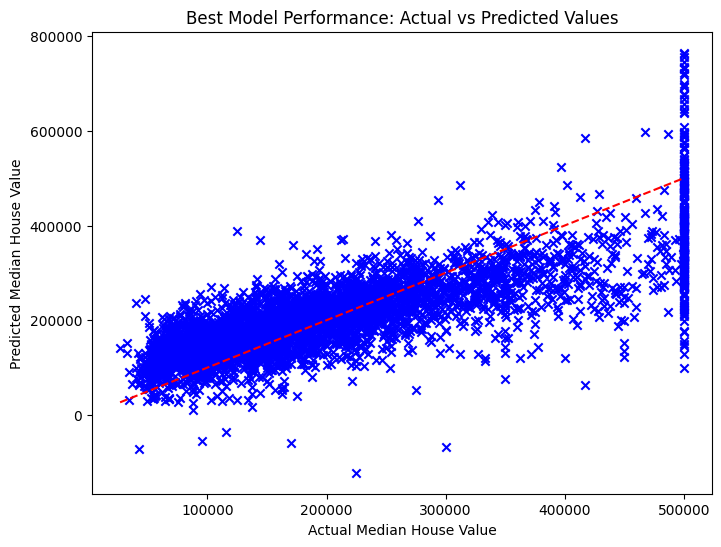

In [22]:
# Extract the best model's predictors
best_model_row = regression_output_df.sort_values(by=["Adjusted R-Squared", "R-Squared"], ascending=False).iloc[0]
best_predictors = best_model_row["Predictors Used"].split(", ")

# Redo the model
X_best = df[best_predictors]
y_best = df['median_house_value']
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X_best, y_best, test_size=0.2, random_state=1)
best_model = LinearRegression()
best_model.fit(X_train_best, y_train_best)

y_pred_best = best_model.predict(X_test_best)

# Plot result
plt.figure(figsize=(8, 6))
plt.scatter(y_test_best, y_pred_best, color='blue',marker='x')
plt.plot([y_test_best.min(), y_test_best.max()], [y_test_best.min(), y_test_best.max()], '--r')
plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted Median House Value")
plt.title("Best Model Performance: Actual vs Predicted Values")
plt.show()


Knowing the best set of variables to use, we can now randomly sample different sample sizes of the dataset to see the effects of CLT.

In [23]:
#Redefine the sample sizes for CLT verification
sample_sizes = [50, 100, 500, 1000, 5000]
num_iterations = 40

clt_results = []

# Resampling with varying sample sizes
for sample_size in sample_sizes:
    for _ in range(num_iterations):
        sampled_df = df.sample(sample_size, replace=True, random_state=np.random.randint(10000))

        X = sampled_df[best_predictors]
        y = sampled_df['median_house_value']
        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)

        # Calculate performance
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(mse)

        # Store results
        clt_results.append({
            "Sample Size": sample_size,
            "Mean Squared Error": mse,
            "Mean Absolute Error": mae,
            "R-Squared": r2,
            "Root Mean Squared Error": rmse
        })

clt_results_df = pd.DataFrame(clt_results)

# Aggregate results by sample size
clt_summary = clt_results_df.groupby("Sample Size").agg(
    Mean_R2=("R-Squared", "mean"),
    Std_R2=("R-Squared", "std"),
    Mean_RMSE=("Root Mean Squared Error", "mean"),
    Std_RMSE=("Root Mean Squared Error", "std")
).reset_index()

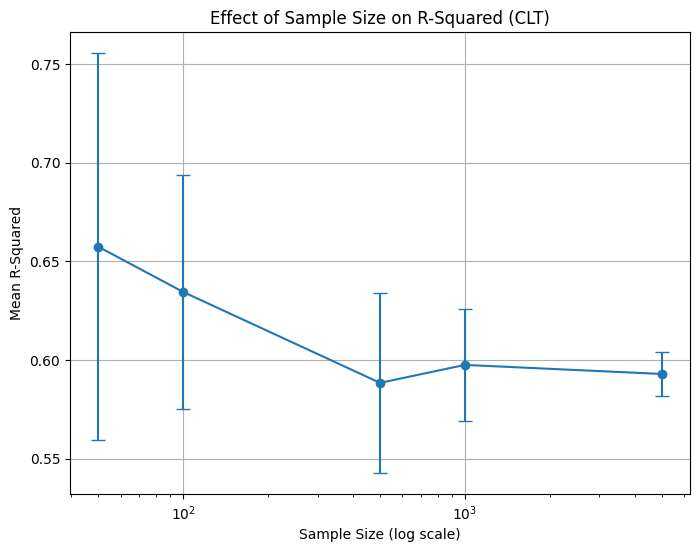

,Sample Size,Mean_R2,Std_R2,Mean_RMSE,Std_RMSE
0,50,0.657426,0.098073,67939.502297,10933.779608
1,100,0.634502,0.059338,71205.609753,6409.836982
2,500,0.588406,0.045740,74174.845561,4209.713104
3,1000,0.597504,0.028261,72989.407535,2428.178787
4,5000,0.592909,0.011028,73698.108584,1057.297217


In [24]:
# Plot
plt.figure(figsize=(8, 6))
plt.errorbar(clt_summary["Sample Size"], clt_summary["Mean_R2"], yerr=clt_summary["Std_R2"], fmt='-o', capsize=5)
plt.xscale("log")
plt.xlabel("Sample Size (log scale)")
plt.ylabel("Mean R-Squared")
plt.title("Effect of Sample Size on R-Squared (CLT)")
plt.grid(True)
plt.show()

clt_summary